Import Dependencies 

In [1]:
# !git clone https://github.com/tmengel/Deep-Learning.git
# %cd Deep-Learning/finalProject
# %pip install uproot
# %pip install pandas

# from google.colab import drive
# drive.mount('/content/drive')

import pulsenet as pn
import tensorflow as tf
import tensorflow.keras as keras
from tensorflow.keras import layers, models
import pandas as pd

2023-05-10 18:00:14.880870: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-05-10 18:00:15.201945: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /home/tmengel/root/lib
2023-05-10 18:00:15.201970: I tensorflow/compiler/xla/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.
2023-05-10 18:00:16.370463: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared obj

File name

Created 261852 samples: 100.0 % pileup, 0.0 % no pileup


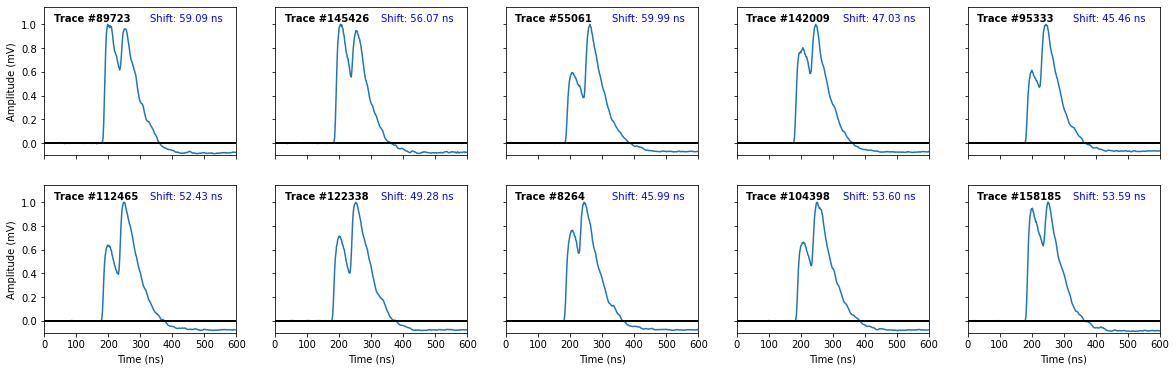

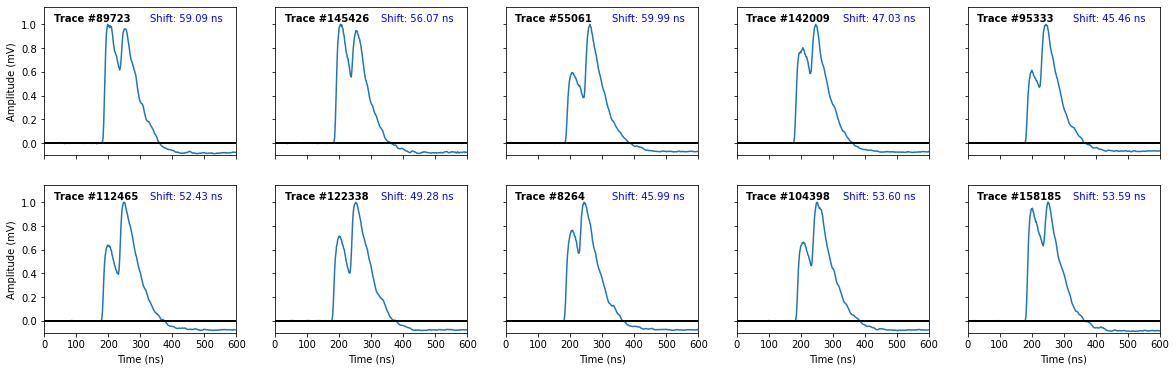

In [4]:
filename = "ysoTracesWithPileup.root"
x_trace, y_trace, y_phase, y_amp = pn.CreateData(filename, pileup_split=1.0, phase_min=40, phase_max=60, amplitude_min=0.5, amplitude_max=1.5)
y_pileup = pn.EncodePileup(y_phase)
pn.PlotTraces(x_trace, y_phase, y_pileup, n=10)

In [2]:
filename = "ysoTracesWithPileup.root"
# filename = "/content/drive/MyDrive/DeepLearningFinalProject/ysoTracesWithPileup.root"

Data Preview

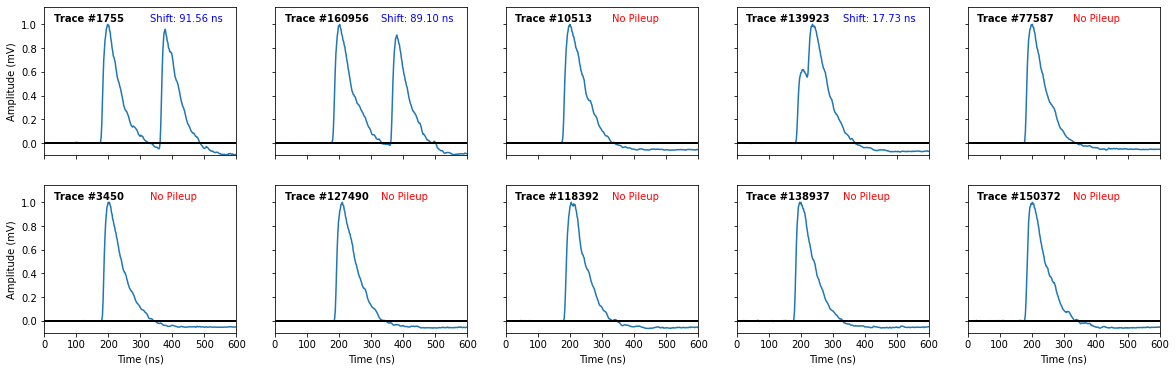

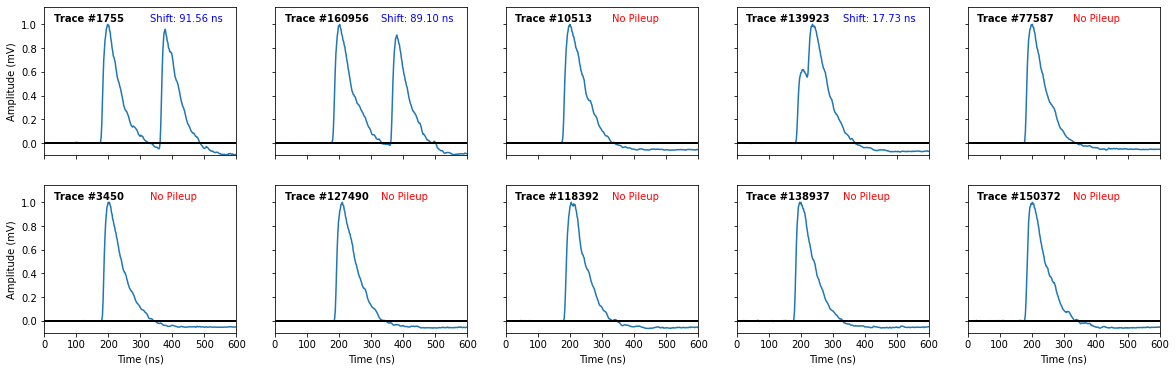

In [10]:
traces, phases, pileup = pn.LoadData(filename)
pn.PlotTraces(traces, phases, pileup, n = 10)

Train All initial Models

**Autoencoder**

In [ ]:
def TrainIndividualModules(model, x, y, weightfile, historyfile, epochs=100, batch_size=128, validation_split=0.2, verbose=1):
    # Train model
    history = model.fit(x, y, epochs=epochs, batch_size=batch_size, validation_split=validation_split, verbose=verbose)
    # Save model weights
    model.layers[0].save_weights(weightfile)
    # Save training history
    pd.DataFrame(history.history, index=history.epoch, columns=history.history.keys()).to_hdf(historyfile, key="hist")

In [ ]:
# Train Discriminator
# Get Data
x_trace, y_trace, y_phase, y_amp = pn.CreateData(filename, pileup_split=1.0, phase_min=0.1, phase_max=20, amplitude_min=0.5, amplitude_max=1.5)

# output files
historyfile = "history/discriminator_initial_history.h5"

# Create model
model = keras.Sequential([
    pn.TraceDiscriminatorBase(name="discriminator_base"),
    pn.TraceDiscriminatorHead(name="discriminator_head")
])
model.compile(optimizer='adam', loss='mse', metrics=['accuracy'])

# Train model
history = model.fit(x_trace, y_trace, epochs=200, batch_size=128, validation_split=0.2, verbose=1)
model.layers[0].save_weights("weights/discriminator_base_initial.h5")
model.layers[1].save_weights("weights/discriminator_head_initial.h5")
pd.DataFrame(history.history, index=history.epoch, columns=history.history.keys()).to_hdf(historyfile, key="hist")

!cp -rf weights /content/drive/MyDrive/DeepLearningFinalProject/
!cp -rf history /content/drive/MyDrive/DeepLearningFinalProject/

In [ ]:
# Train Classifier
# Get Data
x_trace, y_trace, y_phase, y_amp = pn.CreateData(filename, pileup_split=0.5, phase_min=0.1, phase_max=20, amplitude_min=0.5, amplitude_max=1.5)
y_pileup = pn.EncodePileup(y_phase)
# output files
historyfile = "history/classifier_initial_history.h5"

# Create model
model = keras.Sequential([
    pn.TraceClassifierBase(name="classifier_base"),
    pn.TraceClassifierHead(name="classifier_head")
])
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Train model
history = model.fit(x_trace, y_pileup, epochs=200, batch_size=128, validation_split=0.2, verbose=1)
model.layers[0].save_weights("weights/classifier_base_initial.h5")
model.layers[1].save_weights("weights/classifier_head_initial.h5")
pd.DataFrame(history.history, index=history.epoch, columns=history.history.keys()).to_hdf(historyfile, key="hist")

!cp -rf weights /content/drive/MyDrive/DeepLearningFinalProject/
!cp -rf history /content/drive/MyDrive/DeepLearningFinalProject/

In [ ]:
# Train Amplitude Regressor
# Get Data
x_trace, y_trace, y_phase, y_amp = pn.CreateData(filename, pileup_split=0.5, phase_min=0.1, phase_max=20, amplitude_min=0.5, amplitude_max=1.5)
# output files
historyfile = "history/amplitude_regressor_initial_history.h5"

# Create model
model = keras.Sequential([
    pn.TraceAmplitudeRegressor(name = "amplitude_regressor")
])
model.compile(optimizer='adam', loss="mse", metrics=['accuracy'])

# Train model
history = model.fit(x_trace, y_amp, epochs=200, batch_size=128, validation_split=0.2, verbose=1)
model.layers[0].save_weights("weights/amplitude_regressor_initial.h5")
pd.DataFrame(history.history, index=history.epoch, columns=history.history.keys()).to_hdf(historyfile, key="hist")

!cp -rf weights /content/drive/MyDrive/DeepLearningFinalProject/
!cp -rf history /content/drive/MyDrive/DeepLearningFinalProject/

In [ ]:
# Train Phase Regressor
# Get Data
x_trace, y_trace, y_phase, y_amp = pn.CreateData(filename, pileup_split=0.5, phase_min=0.1, phase_max=20, amplitude_min=0.5, amplitude_max=1.5)
# output files
historyfile = "history/phase_regressor_initial_history.h5"

# Create model
model = keras.Sequential([
    pn.TracePhaseRegressor(name = "phase_regressor")
])
model.compile(optimizer='adam', loss="mse", metrics=['accuracy'])

# Train model
history = model.fit(x_trace, y_phase, epochs=200, batch_size=128, validation_split=0.2, verbose=1)
model.layers[0].save_weights("weights/phase_regressor_initial.h5")
pd.DataFrame(history.history, index=history.epoch, columns=history.history.keys()).to_hdf(historyfile, key="hist")

!cp -rf weights /content/drive/MyDrive/DeepLearningFinalProject/
!cp -rf history /content/drive/MyDrive/DeepLearningFinalProject/

In [3]:
input = layers.Input(shape=(1, 300))  # Returns a placeholder tensor
classifer_featurevec = pn.TraceClassifierBase(name = "pileup_classifier_base")(input)
discriminator_featurevec = pn.TraceDiscriminatorBase(name = "trace_discriminator_base")(input)
trace_discriminator_output = pn.TraceClassifierDiscriminatorHead(name = "trace_discriminator_classifier_head")([discriminator_featurevec, classifer_featurevec])
phase_output = pn.TracePhaseRegressor(name = "phase_regressor")(trace_discriminator_output)
amplitude_output = pn.TraceAmplitudeRegressor(name = "amplitude_regressor")(trace_discriminator_output)

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 1, 300)]     0           []                               
                                                                                                  
 trace_discriminator_base (Trac  (None, 2, 300)      992358      ['input_2[0][0]']                
 eDiscriminatorBase)                                                                              
                                                                                                  
 pileup_classifier_base (TraceC  (None, 1, 300)      244456      ['input_2[0][0]']                
 lassifierBase)                                                                                   
                                                                                              

In [20]:
input = layers.Input(shape=(1, 300))  # Returns a placeholder tensor
classifer_featurevec = pn.TraceClassifierBase(name = "pileup_classifier_base")(input)
discriminator_featurevec = pn.TraceDiscriminatorBase(name = "trace_discriminator_base")(input)
trace_discriminator_output = pn.TraceClassifierDiscriminatorHead(name = "trace_discriminator_classifier_head")([discriminator_featurevec, classifer_featurevec])
phase_output = pn.TracePhaseRegressor(name = "phase_regressor")(trace_discriminator_output)
amplitude_output = pn.TraceAmplitudeRegressor(name = "amplitude_regressor")(trace_discriminator_output)

model = models.Model(inputs=input, outputs=trace_discriminator_output)
model.compile(optimizer='adam', loss="mse", metrics=['accuracy'])

# load weights
model.layers[1].load_weights("weights/classifier_base_initial.h5")
model.layers[3].load_weights("weights/discriminator_base_initial.h5")

model.layers[1].trainable = False
model.layers[3].trainable = False
model.summary()
# Train Discriminator Head
# Get Data
x_trace, y_trace, y_phase, y_amp = pn.CreateData(filename, pileup_split=0.5, phase_min=0.1, phase_max=20, amplitude_min=0.5, amplitude_max=1.5)
historyfile = "history/discriminator_classifier_head_transfer_history.h5"

history = model.fit(x_trace, y_trace, epochs=200, batch_size=128, validation_split=0.2, verbose=1)
model.layers[2].save_weights("weights/discriminator_classifier_head_transfer.h5")
pd.DataFrame(history.history, index=history.epoch, columns=history.history.keys()).to_hdf(historyfile, key="hist")

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 1, 300)]     0           []                               
                                                                                                  
 trace_classifier_1 (TraceClass  (None, 1)           199349      ['input_2[0][0]']                
 ifier)                                                                                           
                                                                                                  
 trace_discriminator_head (Trac  (None, 300)         306304      ['input_2[0][0]',                
 eClassifierDiscriminatorHead)                                    'trace_classifier_1[0][0]']     
                                                                                            

In [ ]:
input = layers.Input(shape=(1, 300))  # Returns a placeholder tensor
classifer_featurevec = pn.TraceClassifierBase(name = "pileup_classifier_base")(input)
discriminator_featurevec = pn.TraceDiscriminatorBase(name = "trace_discriminator_base")(input)
trace_discriminator_output = pn.TraceClassifierDiscriminatorHead(name = "trace_discriminator_classifier_head")([discriminator_featurevec, classifer_featurevec])
phase_output = pn.TracePhaseRegressor(name = "phase_regressor")(trace_discriminator_output)
amplitude_output = pn.TraceAmplitudeRegressor(name = "amplitude_regressor")(trace_discriminator_output)

model = models.Model(inputs=input, outputs=[phase_output, amplitude_output])
model.compile(optimizer='adam', loss="mse", metrics=['accuracy'])

# load weights
model.layers[1].load_weights("weights/pileup_classifier_initial.h5")
model.layers[2].load_weights("weights/discriminator_head_transfer_phase_amplitude.h5")
model.layers[3].load_weights("weights/discriminator_initial.h5")
model.layers[4].load_weights("weights/phase_regressor_initial.h5")
model.layers[5].load_weights("weights/amplitude_regressor_initial.h5")

model.layers[1].trainable = False
model.layers[3].trainable = False
model.layers[4].trainable = False
model.layers[5].trainable = False

model.summary()
# Train Discriminator Head
# Get Data
x_trace, y_trace, y_phase, y_amp = pn.CreateData(filename, pileup_split=0.5, phase_min=1, phase_max=20, amplitude_min=0.5, amplitude_max=1.5)
historyfile = "history/discriminator_head_transfer_final_history.h5"
weightfile = "weights/discriminator_head_transfer_final.h5"

history = model.fit(x_trace, y_trace, epochs=100, batch_size=128, validation_split=0.2, verbose=1)
model.layers[2].save_weights(weightfile)
pd.DataFrame(history.history, index=history.epoch, columns=history.history.keys()).to_hdf(historyfile, key="hist")

In [ ]:
input = layers.Input(shape=(1, 300))  # Returns a placeholder tensor
classifer_output = pn.TraceClassifier(name = "pileup_classifier")(input)
trace_discriminator_input = pn.TraceClassifierDiscriminatorHead(name = "trace_discriminator_head")([input, classifer_output])
trace_discriminator_output = pn.TraceDiscriminator(name = "trace_discriminator")(trace_discriminator_input)
phase_output = pn.TracePhaseRegressor(name = "phase_regressor")(trace_discriminator_output)
amplitude_output = pn.TraceAmplitudeRegressor(name = "amplitude_regressor")(trace_discriminator_output)

model = models.Model(inputs=input, outputs=[trace_discriminator_output, phase_output, amplitude_output])
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001), loss=["binary_crossentropy", "mse", "mse", "mse"], metrics=['accuracy'])

# load weights
model.layers[1].load_weights("weights/pileup_classifier_fine_tuned_to_phase_and_amplitude.h5")
model.layers[2].load_weights("weights/discriminator_head_fine_tuned_to_phase_and_amplitude.h5")
model.layers[3].load_weights("weights/discriminator_fine_tuned_to_phase_and_amplitude.h5")
model.layers[4].load_weights("weights/phase_regressor_fine_tuned_to_phase_and_amplitude.h5")
model.layers[5].load_weights("weights/amplitude_regressor_fine_tuned_to_phase_and_amplitude.h5")

# model.layers[1].trainable = False
# model.layers[3].trainable = False
# model.layers[4].trainable = False
# model.layers[5].trainable = False

model.summary()
# Train Discriminator Head
# Get Data
x_trace, y_trace, y_phase, y_amp = pn.CreateData(filename, pileup_split=0.5, phase_min=1, phase_max=20, amplitude_min=0.5, amplitude_max=1.5)
historyfile = "history/final_history.h5"

history = model.fit(x_trace, y_trace, epochs=200, batch_size=128, validation_split=0.2, verbose=1)
model.layers[1].save_weights("weights/pileup_classifier.h5")
model.layers[2].save_weights("weights/discriminator_head.h5")
model.layers[3].save_weights("weights/discriminator.h5")
model.layers[4].save_weights("weights/phase_regressor.h5")
model.layers[5].save_weights("weights/amplitude_regressor.h5")

pd.DataFrame(history.history, index=history.epoch, columns=history.history.keys()).to_hdf(historyfile, key="hist")